In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import re
from models import *
from plot_utils import *
from math import ceil
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = (10, 6.5)
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 4

sns.set_style('ticks')
sns.set_palette('Paired', 10)

In [3]:
rmse_df = pd.read_csv('rmse.csv')
sampling_df = pd.read_csv('../decision-rule/simdex-decision-rule.csv')

simdex_netflix_df = pd.read_csv('timing-results/netflix-simdex-timing.csv')
blocked_mm_netflix_df = pd.read_csv('timing-results/netflix-blocked_mm-timing.csv')

simdex_kdd_df = pd.read_csv('timing-results/kdd-simdex-timing.csv')
blocked_mm_kdd_df = pd.read_csv('timing-results/kdd-blocked_mm-timing.csv')

simdex_r2_df = pd.read_csv('timing-results/r2-simdex-timing.csv')
blocked_mm_r2_df = pd.read_csv('timing-results/r2-blocked_mm-timing.csv')

simdex_lastfm_df = pd.read_csv('timing-results/lastfm-simdex-timing.csv')
blocked_mm_lastfm_df = pd.read_csv('timing-results/lastfm-blocked_mm-timing.csv')

simdex_glove_df = pd.read_csv('timing-results/glove-simdex-timing.csv')
blocked_mm_glove_df = pd.read_csv('timing-results/glove-blocked_mm-timing.csv')

simdex_df = pd.concat([simdex_netflix_df, simdex_kdd_df, simdex_r2_df, simdex_lastfm_df, simdex_glove_df])
lemp_df = pd.read_csv('timing-results/lemp-gold-standard-timing.csv')
blocked_mm_df = pd.concat([blocked_mm_netflix_df, blocked_mm_kdd_df, blocked_mm_r2_df,blocked_mm_lastfm_df,
                           blocked_mm_glove_df])
both_df = pd.concat([simdex_df, blocked_mm_df])

fexipro_df_all = pd.read_csv('timing-results/fexipro-orig-timing.csv')
fexipro_df = fexipro_df_all.query('alg == "SIR"')
fexipro_si_df = fexipro_df_all.query('alg == "SI"')

fexipro_estimates = pd.read_csv('runtime-estimates/fexipro.csv')
lemp_estimates = pd.read_csv('runtime-estimates/lemp.csv')
simdex_estimates = pd.read_csv('runtime-estimates/simdex.csv')
blocked_mm_esitmates = pd.read_csv('runtime-estimates/blocked_mm.csv')

In [4]:
simdex_df

,K,algo_time,batch_size,cluster_time,comp_time,index_time,model,num_bins,num_clusters,num_items,num_iters,num_latent_factors,num_threads,num_users,parse_time,sample_percentage
0,1,27.0105,4096,0.037448,27.0758,0.027845,bpr-Netflix-10-reg-0.00001,1,1,NaN,3,11,1,NaN,3.45577,10
1,1,26.2439,4096,0.138965,26.4201,0.037204,bpr-Netflix-10-reg-0.00001,1,16,NaN,3,11,1,NaN,3.44707,10
2,1,27.0507,4096,0.048478,27.1303,0.031065,bpr-Netflix-10-reg-0.00001,1,2,NaN,3,11,1,NaN,3.42890,10
3,1,26.6806,4096,0.225763,26.9459,0.039511,bpr-Netflix-10-reg-0.00001,1,32,NaN,3,11,1,NaN,3.50212,10
4,1,25.8460,4096,0.063422,25.9449,0.035471,bpr-Netflix-10-reg-0.00001,1,4,NaN,3,11,1,NaN,3.44905,10
5,1,26.2614,4096,0.387534,26.6913,0.042384,bpr-Netflix-10-reg-0.00001,1,64,NaN,3,11,1,NaN,3.44723,10
6,1,26.3703,4096,0.093170,26.5003,0.036838,bpr-Netflix-10-reg-0.00001,1,8,NaN,3,11,1,NaN,3.44290,10
7,10,34.4349,4096,0.037478,34.5004,0.028046,bpr-Netflix-10-reg-0.00001,1,1,NaN,3,11,1,NaN,3.43163,10
8,10,34.4121,4096,0.139294,34.5891,0.037731,bpr-Netflix-10-reg-0.00001,1,16,NaN,3,11,1,NaN,3.25721,10
9,10,35.0802,4096,0.046654,35.1568,0.029944,bpr-Netflix-10-reg-0.00001,1,2,NaN,3,11,1,NaN,3.46114,10


In [5]:
print(simdex_df.query('model == "nomad-R2-50-reg-0.000001" and K == 1')['comp_time'].min())
print(lemp_df.query('model == "nomad-R2-50-reg-0.000001" and K == 1')['comp_time'].min())
print(blocked_mm_df.query('model == "nomad-R2-50-reg-0.000001" and K == 1')['comp_time'].min())


239.577
277.264
1044.38


In [6]:
temp = simdex_df.sort_values(by='comp_time').groupby(
        ['model', 'K'], as_index=False).first().drop(['num_threads','num_latent_factors',
                                                     'num_bins','sample_percentage',
                                                      'num_iters', 'parse_time'], axis=1)
max((temp['cluster_time'] / temp['comp_time'])*100)

11.792082164668956

In [7]:
print(blocked_mm_df.query('model == "nomad-Netflix-25-reg-0.05" and K == 1')['comp_time'].min())
print(lemp_df.query('model == "nomad-Netflix-25-reg-0.05" and K == 1')['comp_time'].min())
print(fexipro_si_df.query('model == "nomad-Netflix-25-reg-0.05" and K == 1')['comp_time'].min())

23.1927
42.8341
71.910119


FU Plots
Appetizer plots
RMSE plots


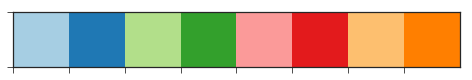

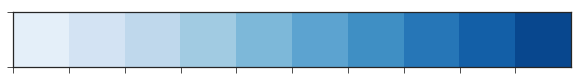

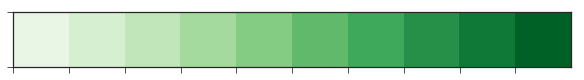

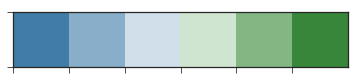

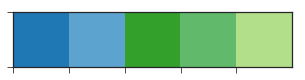

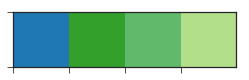

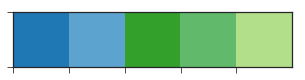

In [8]:
palette = sns.color_palette('Paired', 4)
blue_palette = sns.color_palette('Blues', 10)
green_palette = sns.color_palette('Greens', 10)
f_u_palette = [palette[1], blue_palette[-5], palette[3], green_palette[-5], palette[2]]
# appetizer_palette = [palette[1], palette[3]]
appetizer_palette = f_u_palette[0:1] + f_u_palette[2:]
# rmse_reg_palette = [palette[1], palette[0], palette[3]]
rmse_reg_palette = f_u_palette #[blue_palette[-5], palette[0], palette[3], green_palette[-5], palette[2]]
# rmse_reg_palette = [f_u_palette[3], f_u_palette[1], f_u_palette[4], f_u_palette[2], f_u_palette[5]]

sns.palplot(sns.color_palette('Paired', 8))
sns.palplot(sns.color_palette('Blues', 10))
sns.palplot(sns.color_palette('Greens', 10))
sns.palplot(sns.diverging_palette(240, 128, n=6))
print('FU Plots')
sns.palplot(f_u_palette)
print('Appetizer plots')
sns.palplot(appetizer_palette)
print('RMSE plots')
sns.palplot(rmse_reg_palette)

In [ ]:
for model in GLOVE_MODELS:
    f_u_plot_single(simdex_df, lemp_df, blocked_mm_df, fexipro_df,
                    fexipro_si_df, sampling_df, model=model, num_clusters=8)

In [ ]:
for model in BPR_GOLD_STANDARD_MODELS:
    f_u_plot_single(simdex_df, lemp_df, blocked_mm_df, fexipro_df,
                    fexipro_si_df, sampling_df, model=model, num_clusters=8)

In [ ]:
with sns.color_palette(f_u_palette):
    f_u_plots(simdex_df, lemp_df, blocked_mm_df, fexipro_df, fexipro_si_df, sampling_df,
              GOLD_STANDARD_MODELS, figsize=(28, 21), # 15
              bbox_to_anchor=(0,0,1, 1.04), nrows=5) # 1.06

lemp-paper-Netflix-noav-10 [  7.96533155e-06   8.13532297e-06   8.89405157e-06   1.06156476e-05]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
lemp-paper-Netflix-noav-50 [  3.38260756e-06   3.63154326e-06   3.69756766e-06   4.42273321e-06]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
lemp-paper-Netflix-noav-100 [  3.44984854e-06   3.62720452e-06   3.71129667e-06   4.25965035e-06]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
nomad-Netflix-10-reg-0.05 [  7.45636144e-06   7.67934920e-06   7.93620578e-06   1.02724438e-05]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
nomad-Netflix-25-reg-0.05 [  3.97150232e-06   4.11056194e-06   4.49268575e-06   5.62665054e-06]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
nomad-Netflix-50-reg-0.05 [  3.42871354e-06   3.68187561e-06   3.58065927e-06   4.51128882e-06]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
nomad-Netflix-100-reg-0.05 [  3.47956146e-06   3.62403616e-06   3.60424226e-06   4.40486426e-06]
1 4096 8
5 4096 8
10 4096 8
50 4096 8
bpr-Netflix-10-reg-0.00001 [  2.70830184e-06   2.87234013

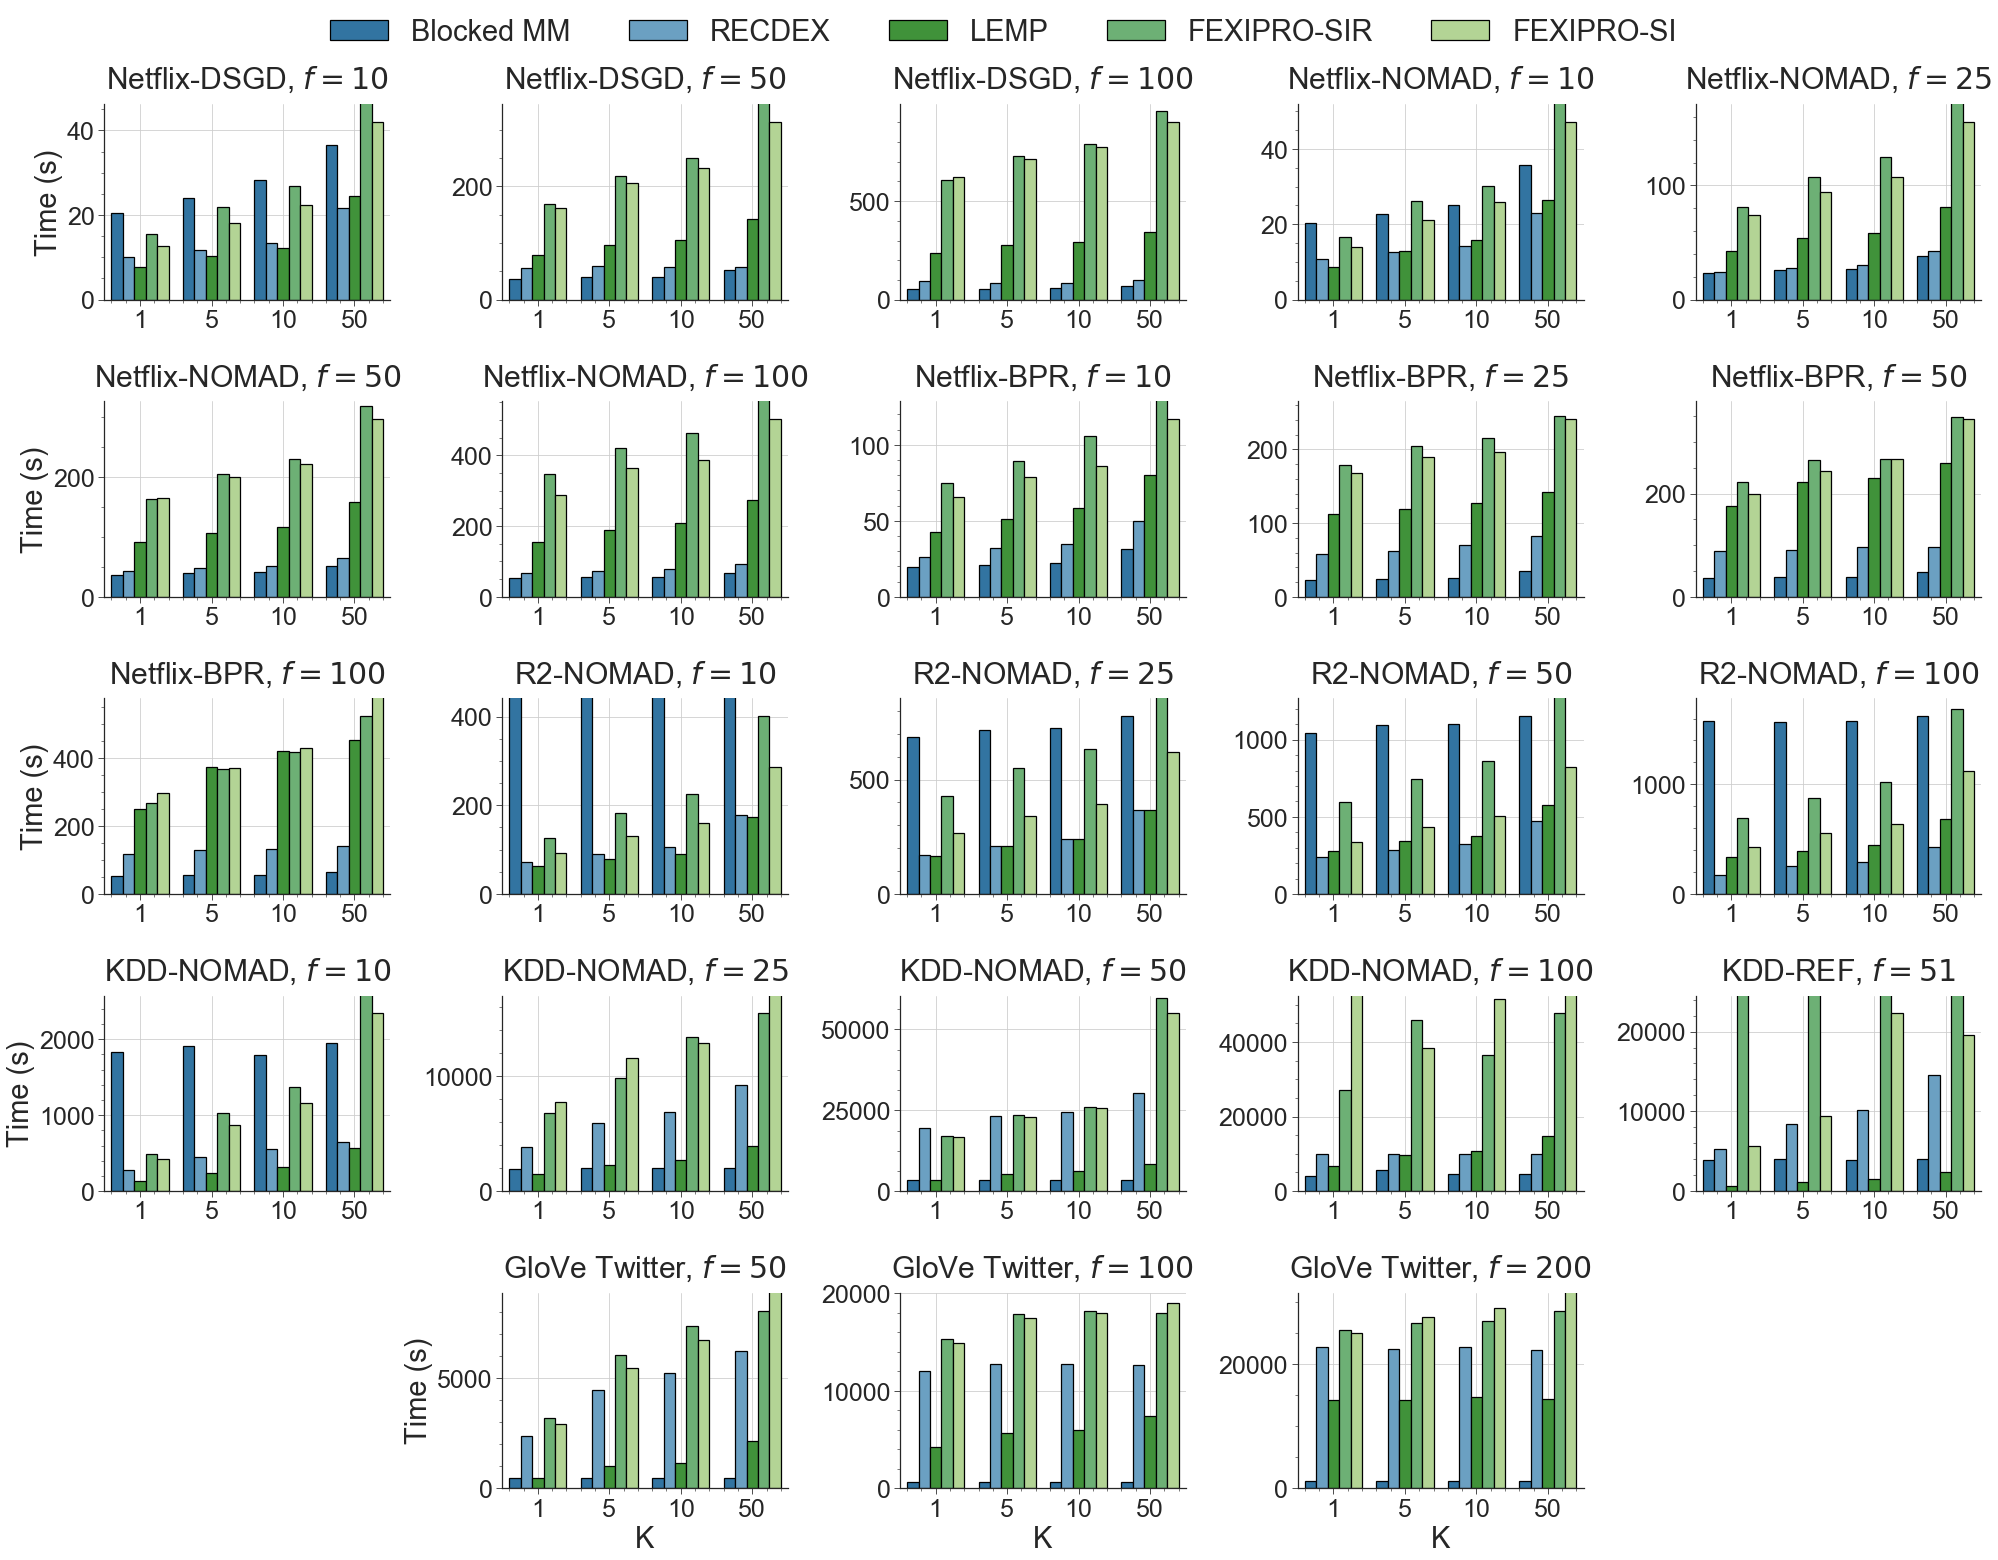

In [80]:
with sns.color_palette(f_u_palette):
    f_u_plots(simdex_df, lemp_df, blocked_mm_df, fexipro_df, fexipro_si_df, sampling_df,
              GOLD_STANDARD_MODELS, figsize=(28, 21), # 15
              bbox_to_anchor=(0,0,1, 1.04), nrows=5) # 1.06

In [ ]:
with sns.color_palette(appetizer_palette):
    blocked_mm_lemp_fexipro_plot(blocked_mm_df, lemp_df, fexipro_df, fexipro_si_df,
                             'nomad-R2-50-reg-0.001', y_title=1.01, figsize=(7, 5.5), title=r'Yahoo Music R2, $f=50$')
    blocked_mm_lemp_fexipro_plot(blocked_mm_df, lemp_df, fexipro_df, fexipro_si_df,
                             'nomad-Netflix-50-reg-0.05', y_title=1.01, figsize=(7, 5.5),
                             title=r'Netflix Prize, $f=50$')

In [ ]:
# custom settings for the line plots
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 19
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4

runtime_estimates_plot([
                        'lemp-paper-KDD-50',
#                         'lemp-paper-Netflix-noav-50',
#                         'nomad-KDD-50-reg-1',
#                         'nomad-Netflix-50-reg-0.05',
#                         'nomad-R2-50-reg-0.000001',
                       ], lemp_estimates, lemp_df, fexipro_estimates, fexipro_df_all, simdex_estimates, simdex_df,
                        blocked_mm_esitmates, blocked_mm_df, markerstyle='X',
                      figsize=(8,3.5))

# return to normal
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4

In [ ]:
# custom settings for the line plots
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['figure.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 21
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.markersize'] = 12
plt.rcParams['lines.linewidth'] = 3.5

appetizer_models = [
    ('nomad-Netflix-25', NETFLIX_REGS, (10, 125), r'Netflix-NOMAD, $f=25$'),
    ('nomad-R2-25', R2_REGS, (-25, 80), r'R2-NOMAD, $f=25$')    
]

all_models = [
    ('nomad-Netflix-50', NETFLIX_REGS, (-5, 135), r'Netflix-NOMAD, $f=50$'),
    ('nomad-Netflix-100', NETFLIX_REGS, (-5, 135), r'Netflix-NOMAD, $f=100$'),
    ('nomad-R2-50', R2_REGS[:-1], (15, 150), r'R2-NOMAD, $f=50$'),
    ('nomad-R2-100', R2_REGS[:-1],(60, 120), r'R2-NOMAD, $f=100$'),
    ('nomad-KDD-10', KDD_REGS, (-24, 135), r'KDD-NOMAD, $f=10$'),
]
for add_simdex in [True, False]:
    models = all_models if add_simdex else appetizer_models
    _palette = rmse_reg_palette if add_simdex else appetizer_palette
    for model_prefix, regs, xy_text, title_text in models:
        _simdex_df = simdex_df if add_simdex else None
        fname = 'appetizer-' + model_prefix if not add_simdex else None
        with sns.color_palette(_palette):
            rmse_and_reg_plots(blocked_mm_df, lemp_df, rmse_df, model_prefix, regs,
                               simdex_df=_simdex_df, fexipro_df=fexipro_df, fexipro_si_df=fexipro_si_df,
                               fname=fname, figsize=(5.5, 7),
                               bbox_to_anchor=(0,0,1,1.05), title=add_simdex, title_text=title_text, 
                               y_title=-0.5, annotate=not add_simdex, xy_text=xy_text, linestyle='--', markerstyle='X',
                               include_legend=False)
            rmse_and_reg_legend(add_simdex, linestyle='--', markerstyle='X')
     
# return to normal
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4        
sns.set_palette('Paired', 10)


In [ ]:
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 21
num_clusters_vs_runtime(simdex_df, ['lemp-paper-Netflix-noav-50',
                                    'nomad-Netflix-50-reg-0.05',
                                    'nomad-R2-10-reg-0.001',
                                    'nomad-R2-100-reg-0',
                                   ], figsize=(25, 5), y_title=-0.3,
                            bbox_to_anchor=(0,0,1,1.05), min_value=0, max_value=512)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 29

In [ ]:
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 21

# TODO: lemp-paper-Netflix-noav-50 and nomad-R2-50-reg-0.000001 don't have all the clusters
batch_size_vs_runtime(simdex_df, [
                                  'nomad-Netflix-50-reg-0.05',
                                  'lemp-paper-Netflix-noav-50',
                                  'nomad-R2-50-reg-0.000001',
                                  'nomad-R2-100-reg-0',
                                  ], figsize=(25,5), bbox_to_anchor=(0,0,1,1.05), y_title=-0.3)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 29

In [ ]:
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['lines.linewidth'] = 6
with sns.color_palette(f_u_palette):
    point_query_time(['lemp-paper-Netflix-noav-50', 'nomad-Netflix-50-reg-0.05',
                      'nomad-R2-50-reg-0.001', 'nomad-KDD-50-reg-1'],
                     csv_dir='point-query-stats/', figsize=(32, 6.5),
                     sample_fraction=1.0, y_title=-0.38)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['lines.linewidth'] = 4

In [ ]:
plt.rcParams['font.size'] = 25
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 2.50

factor_analysis(figsize=(8,3))

147      90.742725
329     408.857320
155     143.961760
345    1510.171029
151     151.528452
337    2450.247884
dtype: float64


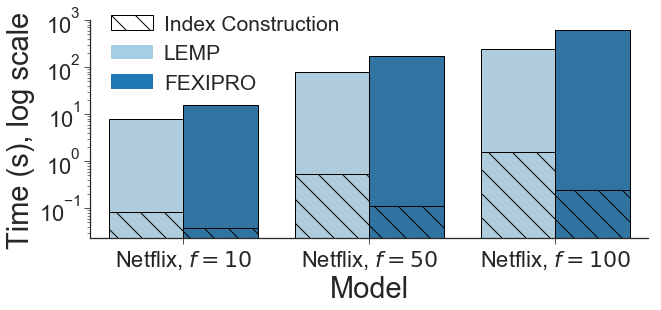

In [81]:
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

lemp_model_df = lemp_df.query('model.str.contains("lemp-paper-Netflix-noav") and K == 1', engine='python')
lemp_data = lemp_model_df[['model', 'num_latent_factors', 'comp_time']]
lemp_data['index_time'] = lemp_model_df['preproc_time'] + lemp_model_df['index_time']
lemp_data['algo'] = 'LEMP'


fexipro_model_df = fexipro_df.query('model.str.contains("lemp-paper-Netflix-noav") and K == 1', engine='python')
fexipro_data = fexipro_model_df[['model', 'num_latent_factors', 'comp_time']]
fexipro_data['index_time'] = fexipro_model_df['preproc_time']
fexipro_data['algo'] = 'FEXIPRO'

data = pd.concat([lemp_data, fexipro_data])
data.replace({"model": LABEL_DICT}, inplace=True)
data.sort_values(by='num_latent_factors', inplace=True)

print((data['comp_time'] - data['index_time']) / data['index_time'])

plt.figure(figsize=(10, 4))
sns.barplot(x='model', y='comp_time', hue='algo', data=data, edgecolor='black')
ax = sns.barplot(x='model', y='index_time', hue='algo', data=data, hatch='\\', edgecolor='black')
ax.legend_.remove()

ax.set_yscale('log')
ax.set_xlabel('Model')
ax.set_ylabel('Time (s), log scale')
xticklabels = [label.get_text().replace('-DSGD', '',) for label in ax1.get_xticklabels()]
ax.set_xticklabels(xticklabels)

lemp_legend = plt.Rectangle((0,0),1,1, edgecolor='none')
fexipro_legend = plt.Rectangle((0,0),1,1, fc=palette[1], edgecolor='none')
index_time_legend = plt.Rectangle((0,0),1,1, fill=False, hatch='\\')

legend = ax.legend([index_time_legend, lemp_legend, fexipro_legend],
                    ['Index Construction', 'LEMP', 'FEXIPRO'],
                    loc='bottom right',                       
                    ncol=1,
                    handletextpad=0.5,
                    columnspacing=1.25,
                    bbox_to_anchor=(0.48, 0.58),
                    fontsize=21)

sns.despine()

save_figure('index-construction', (legend,))

plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

,theta_uc,theta_b,num_items_visited,query_time
cluster_id,,,,
6,0.489594,1.12188,1483,7.429
2,0.505611,1.14017,893,26.153
5,0.564271,1.38390,2117,4.830
0,0.595598,1.43173,997,12.042
4,0.693336,1.49943,1806,5.811
7,0.577477,1.50825,962,4.692
3,0.610142,1.53028,1025,7.028
1,0.638705,1.63197,1047,4.538


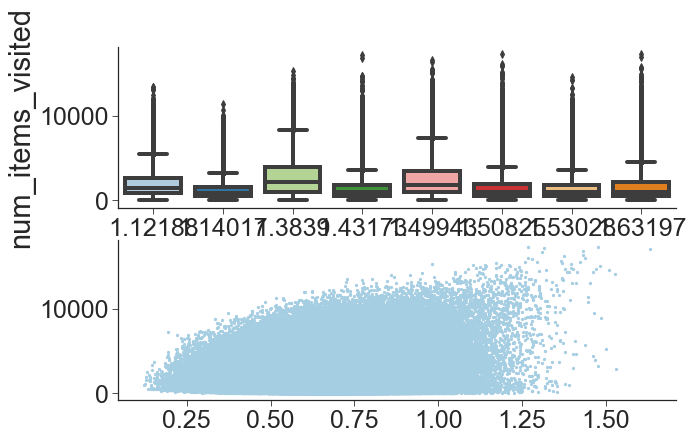

In [113]:
df = pd.read_csv('user-stats.csv')
fig, (ax0, ax1) = plt.subplots(2, 1)
sns.boxplot(x=df["theta_b"], y=df["num_items_visited"], ax=ax0)
ax1.scatter(x=df['theta_uc'], y=df['num_items_visited'], s=5)
sns.despine()
df.groupby('cluster_id').agg('median').sort_values(by='theta_b')